In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mmctools.wrf.utils import tsout_seriesReader
import glob
from mmctools.helper_functions import theta
from os import path
from mmctools.helper_functions import theta_to_T
from mmctools.helper_functions import calc_uv

from osgeo import gdal

***
# Before you run!
<div class="alert alert-block alert-info">
<b>Make sure you have downloaded the ICBC data! </b>

Download the data by running: /glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/ICBC/download_icbcs.py

</div>

***

# Get Obs.

In [3]:
obs_dir = '/glade/work/hawbecke/MMC/FINO/'
obs_year = 2010
fino_obs = {'FINO1': []}
boom_deg = 345
for ff, fino in enumerate([1]):
    fino_obs_name = '{}FINO{}_obs.nc'.format(obs_dir,fino)
    if path.exists(fino_obs_name):
        print('loading in full dataset!')
        fino_obs['FINO{}'.format(fino)] = xr.open_dataset(fino_obs_name)
    else:
        print('Getting obs dataset for {}FINO{}/Year{}/'.format(obs_dir,fino,obs_year))
        fino_obs['FINO{}'.format(fino)] = get_FINO_obs('{}FINO{}/Year{}/'.format(
                                obs_dir,fino,obs_year),FINO=fino,boom_deg=boom_deg)
        fino_obs['FINO{}'.format(fino)].to_netcdf(fino_obs_name)
fino1 = fino_obs['FINO1'].sel(datetime=slice('2010-05-15 00:00:00','2010-05-17 00:00:00'))
ang = np.radians(270. - fino1.wdir.data)
u = fino1.wspd.isel(spd_levels=slice(0,7)).data * np.cos(ang)
v = fino1.wspd.isel(spd_levels=slice(0,7)).data * np.sin(ang)


fino1['U'] = xr.DataArray(data=u,
                          coords={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          dims={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          name='U')
fino1['V'] = xr.DataArray(data=v,
                          coords={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          dims={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          name='V')

loading in full dataset!


# Functions needed in this script:

In [6]:
def time_from_filename(fname,fmt=None):
    if fmt not in ['FNL','ERAI','ERA5']:
        raise ValueError('Currently only FNL, ERAI, and ERA5 are supported')

    if '/' in fname: fname = fname.split('/')[-1]
    
    if fmt == 'FNL':
        fname = fname.replace('.grib2','')
        fname = fname.split('_')
        date_str = fname[1]
        time_str = ':'.join(fname[2:4])
        datetime = pd.to_datetime('{} {}'.format(date_str,time_str))
    elif fmt == 'ERAI':
        datetime = pd.to_datetime(fname.split('.')[-1],format='%Y%m%d%H')
    elif fmt == 'ERA5':
        fname = fname.replace('.grib','')
        date_str = ''.join(fname.split('_')[2:5])
        time_str = '{}:00'.format(fname.split('_')[5])
        datetime = pd.to_datetime('{} {}'.format(date_str,time_str))
        

    return(datetime)

def print_data_vars(ds):
    for d in ds.data_vars:
        #print(ds[d])
        name_key = 'long_name'
        if name_key in ds[d].attrs.keys():
            print(d,ds[d].attrs[name_key])

# Dictionary for ICBC specifics:

In [7]:
icbc_dict = {'FNL': {'file_fmt':'fnl*00.grib2',
                     'file_types':{'pressure':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}},
                                               'variables':{'gh':'z',
                                                            'u':'U',
                                                            'v':'V',
                                                            't':'T',
                                                'isobaricInhPa':'P'},
                                              },
                                   'r':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'isobaricInhPa','paramId':157}},
                                                 'variables':{'r':'RH',
                                                  'isobaricInhPa':'P'},
                                         },
                                   'surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'surface'}},
                                               'variables':{'sp':'PSFC',
                                                             't':'tsk'},
                                              },
                                   'scheights':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'heightAboveGround'}},
                                                 'variables':{'t2m':'T2',
                                                              'q':'Q2'},
                                                },
                                   'u10':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'heightAboveGround','paramId':165}},
                                                 'variables':{'u10':'U10'},
                                         },
                                   'v10':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'heightAboveGround','paramId':166}},
                                                 'variables':{'v10':'V10'},
                                         },
                                   'stl1':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer'}},
                                                 'variables':{'t':'soilT_1',
                                                             'soilw':'soilQ_1'},
                                         },
                                   'stl2':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer'}},
                                                 'variables':{'t':'soilT_2',
                                                             'soilw':'soilQ_2'},
                                         },
                                   'stl3':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer'}},
                                                 'variables':{'t':'soilT_3',
                                                             'soilw':'soilQ_3'},
                                         },
                                   'stl4':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer'}},
                                                 'variables':{'t':'soilT_4',
                                                             'soilw':'soilQ_4'},
                                         },
                                  },
                     'extension':'.grib2',
                     'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}},
                     'height_var':'gh',
                     'geopotential':False,
                     'celsius': False,
                     'color':'g',
                    },
             'ERAI':{'file_fmt':'ei.oper.an.{}.*[0628]',
                     'file_types':{'pl.regn128sc':{'backend_kwargs': None,
                                                   'variables':{'z':'z',
                                                                #'r':'rh',
                                                                'q':'QVAPOR',
                                                                't':'T',
                                                    'isobaricInhPa':'P'},
                                                  },
                                   'pl.regn128uv':{'backend_kwargs': None,
                                                   'variables':{'u':'U',
                                                                'v':'V',
                                                    'isobaricInhPa':'P'},
                                                  },
                                   'sfc.regn128sc':{'backend_kwargs': None,
                                              'variables':{'u10':'U10',
                                                           'v10':'V10',
                                                           't2m':'T2',
                                                           'd2m':'dwpt',
                                                           'sp':'PSFC',
                                                           'sst':'sst',
                                                           'skt':'tsk',
                                                           'stl1':'soilT_1',
                                                           'swvl1':'soilQ_1',
                                                          },
                                              },
                                   'AUX1sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':170}},
                                                 'variables':{'stl2':'soilT_2'},
                                         },
                                   'AUX2sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':183}},
                                                 'variables':{'stl3':'soilT_3'},
                                         },
                                   'AUX3sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':236}},
                                                 'variables':{'stl4':'soilT_4'},
                                         },
                                   'AUX4sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':40}},
                                                 'variables':{'swvl2':'soilQ_2'},
                                         },
                                   'AUX5sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':41}},
                                                 'variables':{'swvl3':'soilQ_3'},
                                         },
                                   'AUX6sfc.regn128sc':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':42}},
                                                 'variables':{'swvl4':'soilQ_4'},
                                         },

                                 },
                     
                     'extension':'',
                     'backend_kwargs': None,
                     'height_var':'z',
                     'geopotential':True,
                     'celsius': False,
                     'color':'darkblue',
                    },
             'ERA5':{'file_fmt':'era5_{}_*.grib',
                     'file_types':{'pressure':{'backend_kwargs': None,
                                               'variables':{'z':'z',
                                                            #'r':'rh',
                                                            'q':'QVAPOR',
                                                            't':'T',
                                                            'u':'U',
                                                            'v':'V',
                                                'isobaricInhPa':'P'},
                                              },
                                   'surface':{'backend_kwargs': None,
                                              'variables':{'u10':'U10',
                                                           'v10':'V10',
                                                           't2m':'T2',
                                                           'd2m':'dwpt',
                                                           'sp':'PSFC',
                                                           'sst':'sst',
                                                           'skt':'tsk',
                                                           'stl1':'soilT_1',
                                                           'swvl1':'soilQ_1',
                                                          },
                                              },
                                   'AUX1surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':170}},
                                                 'variables':{'stl2':'soilT_2'},
                                         },
                                   'AUX2surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':183}},
                                                 'variables':{'stl3':'soilT_3'},
                                         },
                                   'AUX3surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':236}},
                                                 'variables':{'stl4':'soilT_4'},
                                         },
                                   'AUX4surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':40}},
                                                 'variables':{'swvl2':'soilQ_2'},
                                         },
                                   'AUX5surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':41}},
                                                 'variables':{'swvl3':'soilQ_3'},
                                         },
                                   'AUX6surface':{'backend_kwargs': {'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer','paramId':42}},
                                                 'variables':{'swvl4':'soilQ_4'},
                                         },
                                  },

                     'extension':'.grib',
                     'height_var':'z',
                     'geopotential':True,
                     'celsius': False,
                     'color':'darkred',
                    },
             }


# Get ICBC data at FINO location into a dataset:

<div class="alert alert-block alert-info">
<b>Note: You will see a lot of warnings from the output </b>

This is fine... there are ways to supress the output, but if it runs through, it isn't a big problem for now.
    
</div>

In [9]:
# FINO lon,lat = 0.626,53.917
fino_lon = 0.626
fino_lat = 53.917

# Location of ICBC data:
icbc_dir = '/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/ICBC/'

# Initialize dataset dictionary:
icbc_ds_dict = {}

# Loop over ICBCs
for icbc_type in list(icbc_dict.keys())[:]:
    f_dir = '{}{}/'.format(icbc_dir,icbc_type)
    file_types = list(icbc_dict[icbc_type]['file_types'].keys())

    # flag to initialize the dataset
    init_ds = True
    
    # Loop over all file types for this ICBC:
    for f_type in file_types:
        if f_type[:3] == 'AUX': 
            f_type_fmt = f_type[4:]
        else:
            f_type_fmt = f_type
        f_fmt = icbc_dict[icbc_type]['file_fmt'].format(f_type_fmt)
        
        # Find all files of this type:
        f_list = sorted(glob.glob('{}{}'.format(f_dir,f_fmt)))

        f_type_dict = icbc_dict[icbc_type]['file_types'][f_type]
        backend_kwargs = f_type_dict['backend_kwargs']
        data_vars = list(f_type_dict['variables'].keys())
        
        # Loop over files of this type:
        for ff,f_name in enumerate(f_list): 
            # Open as a dataset:
            ds = xr.open_dataset(f_name, engine='cfgrib', 
                                 backend_kwargs=backend_kwargs)

            # Expand dimension to include time:
            datetime = time_from_filename(f_name,fmt=icbc_type)
            ds = ds.expand_dims({'datetime':[datetime]})

            # Only care about certain variables:
            ds = ds[data_vars]
            
            # Get the cell nearest to FINO:
            fino_ds = ds.sel(latitude=fino_lat,longitude=fino_lon,method='nearest')
            fino_ds = fino_ds.rename(f_type_dict['variables'])

            # If first time (init_ds = True), initialize final ds (fino_ds_f)
            if init_ds:
                fino_ds_f = fino_ds.copy()
                init_ds = False
            else:
                # Append fino_ds to final ds (fino_ds_f)
                fino_ds_f = fino_ds_f.combine_first(fino_ds)

    # Calculate height if given geopotential:
    if icbc_dict[icbc_type]['geopotential']:
        fino_ds_f['z'] /= 9.81
        
    # Convert to Kelvin if data is in celsius:
    if icbc_dict[icbc_type]['celsius']:
        fino_ds_f['T'] += 273.15
        fino_ds_f['T2'] += 273.15
        
    # Calculate potential temperature:
    fino_ds_f['theta'] = theta(fino_ds_f.T,fino_ds_f.P)

    var_list = list(fino_ds_f.data_vars)
    
    # Need to get mixing ratio at 2 m... if we have dewpoint then:
    ### there is no "else" for this... ERAI, ERA5, and FNL either
    ### have Q2 or dwpt 
    if ('Q2' not in var_list) and ('dwpt' in var_list):
        T2_degC = fino_ds_f.T2 - 273.15
        p = fino_ds_f.PSFC
        if p.max() > 10000:
            p /= 100.0
        es = 6.11 * 10**(7.5*T2_degC/(237.3+T2_degC))
        w_s = 0.622 * es / (p - es)
        dwpt_C = fino_ds_f.dwpt - 273.15
        e = 6.11 * np.exp((7.5*np.log(10))/((237.3/dwpt_C)+1))
        RH = 100.0 * e/es
        q2 = RH*w_s/100.0
        q2.name = 'Q2'
        fino_ds_f['Q2'] = q2
    
    # Need mixing ratio throughout the column:
    if 'QVAPOR' not in var_list:
        T_degC = fino_ds_f['T'] - 273.15
        p = fino_ds_f.P
        if p.max() > 10000:
            p /= 100.0
        es = 6.11 * 10**(7.5*T_degC/(237.3+T_degC))
        w_s = 0.622 * es / (p - es)
        if 'RH' in var_list:
            RH = fino_ds_f.RH
        else:
            raise ValueError('Need to calculate RH')
        qvapor = RH*w_s/100.0
        qvapor.name = 'QVAPOR'
        fino_ds_f['QVAPOR'] = qvapor


    # FNL has P from low to high, reverse it:
    if icbc_type == 'FNL':
        fino_ds_f = fino_ds_f.sortby('P',ascending=False)
        
    # Store final ds in the ICBC dataset dictionary:
    icbc_ds_dict[icbc_type] = fino_ds_f
    # Save the data for use in another script:
    fino_ds_f.to_netcdf('{0}{1}/extracted_{1}_FINO.nc'.format(icbc_dir,icbc_type))

skipping variable: paramId==260131 shortName='o3mr'
Traceback (most recent call last):
  File "/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/cfgrib/dataset.py", line 602, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/cfgrib/dataset.py", line 538, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000,  975,  950,  925,  900,  850,  800,  750,  700,  650,  600,
        550,  500,  450,  400,  350,  300,  250,  200,  150,  100,   70,
         50,   30,   20,   10])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([100,  70,  50,  30,  20,  10]))
skipping variable: paramId==157 shortName='r'
Traceback (most recent call last):
  File "/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/sit

### Plot the ICBCs to see what we're working with:

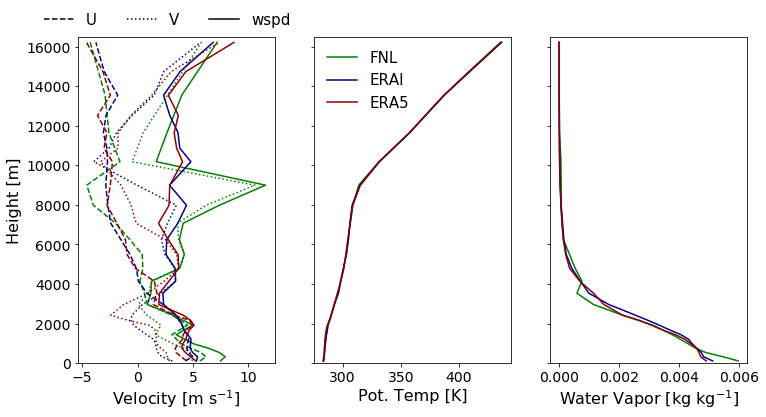

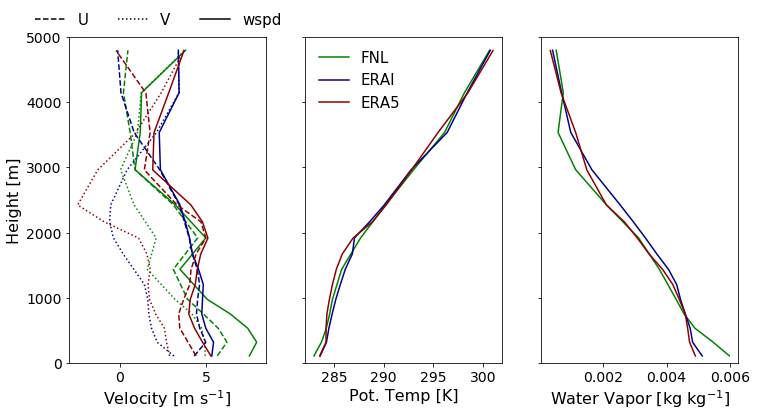

In [88]:
# Going to make 2 of the same plot, but limit y for the second one to near-surface:
maxy_list = [16500,5000]

# Loop over max-y heights:
for maxy in maxy_list:
    # New figure:
    fig,ax = plt.subplots(ncols=3,figsize=(12,6),sharey=True)
    # Loop over ICBCs:
    for icbc_type in icbc_ds_dict:
        max_P = 100
        # Get ICBC dataset:
        ds = icbc_ds_dict[icbc_type].isel(datetime=0)
        ds = ds.where(ds.P>=max_P).dropna(how='all',dim='P')
        # Limit heights to max-y
        ds = ds.where(ds.z <= maxy).dropna(how='all',dim='P')

        # Plot u and v
        ax[0].plot(ds.U,ds.z,c=icbc_dict[icbc_type]['color'],ls='--')
        ax[0].plot(ds.V,ds.z,c=icbc_dict[icbc_type]['color'],ls=':')
        wspd = (ds.U**2 + ds.V**2)**0.5
        ax[0].plot(wspd,ds.z,c=icbc_dict[icbc_type]['color'],ls='-')
        # Plot theta:
        ax[1].plot(ds.theta,ds.z,label=icbc_type,c=icbc_dict[icbc_type]['color'])
        # Plot mixing ratio:
        ax[2].plot(ds.QVAPOR,ds.z,label=icbc_type,c=icbc_dict[icbc_type]['color'])

    # Adjust plots:
    ax[0].plot([],[],ls='--',c='k',label='U')
    ax[0].plot([],[],ls=':',c='k',label='V')
    ax[0].plot([],[],ls='-',c='k',label='wspd')
    ax[0].legend(frameon=False,fontsize=15,ncol=3,loc=(-0.20,1.01))
    ax[1].legend(frameon=False,fontsize=15)
    ax[0].set_xlabel('Velocity [m s$^{-1}$]',size=16)
    ax[1].set_xlabel('Pot. Temp [K]',size=16)
    ax[2].set_xlabel('Water Vapor [kg kg$^{-1}$]',size=16)
    for axi in range(0,3):
        ax[axi].tick_params(labelsize=14)
    ax[0].set_ylim(0,maxy)
    ax[0].set_ylabel('Height [m]',size=16)
    plt.show()

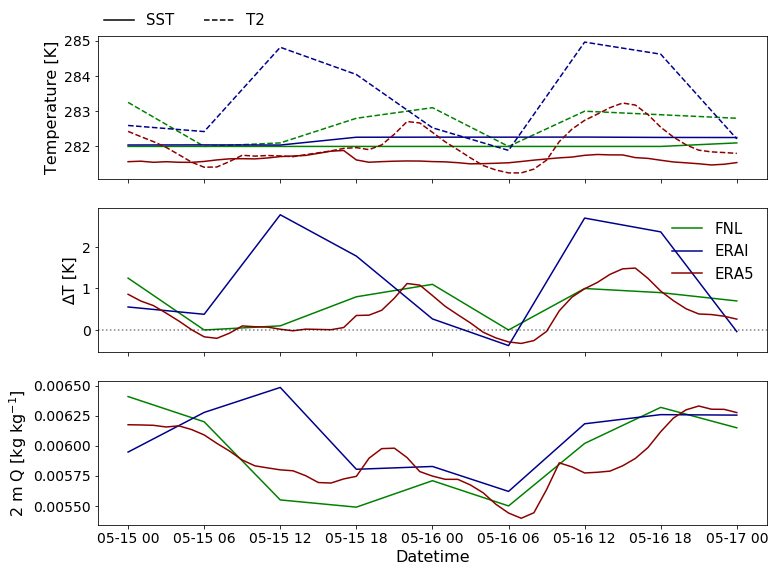

In [30]:
# Timeseries plot:
fig,ax = plt.subplots(nrows=3,figsize=(12,9),sharex=True)
for icbc_type in icbc_ds_dict:
    # Get ICBC dataset:
    ds = icbc_ds_dict[icbc_type].isel(P=0)
    # Plot skin temperature and 2-m temperature:
    ax[0].plot(ds.datetime,ds.tsk,c=icbc_dict[icbc_type]['color'],ls='-')
    ax[0].plot(ds.datetime,ds.T2,c=icbc_dict[icbc_type]['color'],ls='--')
    
    # Calculate difference between skin and T2:
    Tdiff = ds.T2 - ds.tsk
    # Plot difference
    ax[1].plot(ds.datetime,Tdiff,c=icbc_dict[icbc_type]['color'],ls='-',label=icbc_type)

    # Plot surface moisture:
    ax[2].plot(ds.datetime,ds.Q2,c=icbc_dict[icbc_type]['color'],ls='-')

# Adjust plots:
ax[0].plot([],[],ls='-',c='k',label='SST')
ax[0].plot([],[],ls='--',c='k',label='T2')
ax[1].axhline(0,c='k',alpha=0.5,ls=':')
ax[0].legend(frameon=False,fontsize=15,ncol=2,loc=(0.0,1.01))
ax[1].legend(frameon=False,fontsize=15)
ax[0].set_ylabel('Temperature [K]',size=16)
ax[1].set_ylabel('∆T [K]',size=16)
ax[2].set_ylabel('2 m Q [kg kg$^{-1}$]',size=16)
ax[2].set_xlabel('Datetime',size=16)
for axi in range(0,3):
    ax[axi].tick_params(labelsize=14)
plt.show()

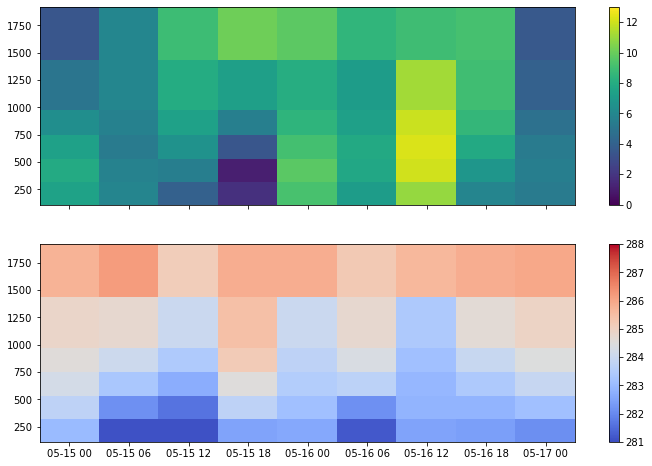

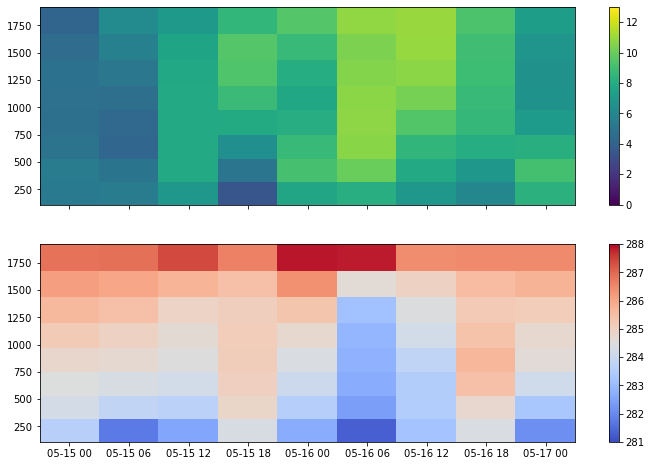

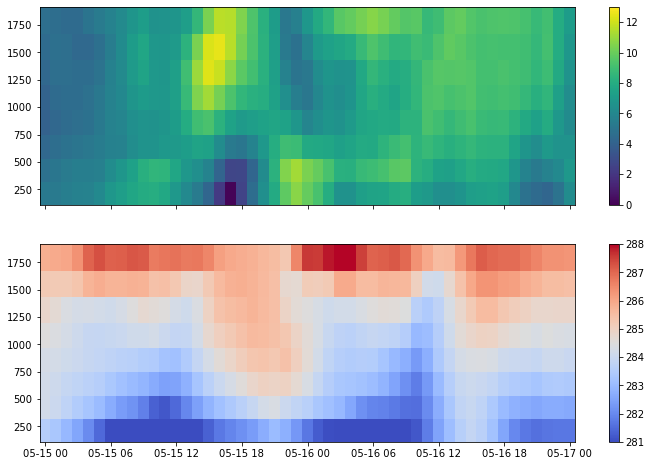

In [81]:
# Time-height plots for wind speed and temperature:
for icbc_type in icbc_ds_dict:
    # New figure:
    fig,ax = plt.subplots(nrows=2,figsize=(12,8),sharey=True,sharex=True)
    # Limit pressure level to lower levels:
    max_P = 800
    # Get ICBC data:
    ds = icbc_ds_dict[icbc_type]
    ds = ds.where(ds.P>=max_P).dropna(how='all',dim='P')
    # Create time/height grid:
    ptime = ds.datetime.data.copy()
    time_delta = np.mean(ptime[1:] - ptime[:-1])#.astype('timedelta64[h]')
    ptime_stag = ptime - time_delta/2
    ptime_stag = np.concatenate((ptime_stag,[ptime_stag[-1] + time_delta]))
    tz,zt = np.meshgrid(np.asarray(ptime_stag),ds.z.isel(datetime=0).data)
    # Calculate wind speed:
    ds['wspd'] = np.sqrt(ds.U**2 + ds.V**2)
    # Plot wind speed and theta:
    wspd_plt = ax[0].pcolormesh(tz,zt,ds.wspd.T,vmin=0,vmax=13)
    temp_plt = ax[1].pcolormesh(tz,zt,ds['theta'].T,cmap=plt.cm.coolwarm,
                                vmin=281,vmax=288)
    # Add colorbars:
    plt.colorbar(wspd_plt,ax=ax[0])
    plt.colorbar(temp_plt,ax=ax[1])

    plt.show()